In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import inspect
import time

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm import tqdm

# The Simplicial Complex

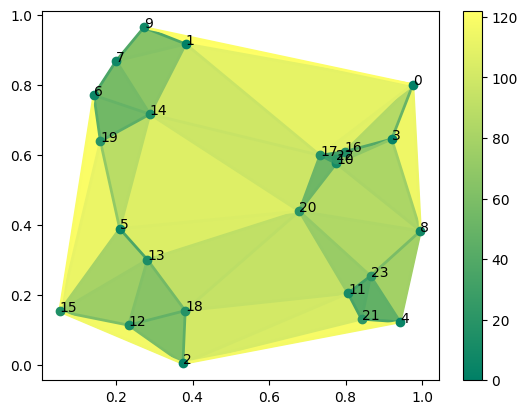

In [3]:
n, dim = 24, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())
enumerate_points(points)

# Define and iterate the Transpositions

In [4]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
def iterate_possible_transpositions_indices(order, neighbours=True):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [6]:
def get_transposition_type(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

In [7]:
def get_transposition(stree: gh.SimplexTree, i0, i1, order=None):
    # 
    if order is None:
        order = [simplex for simplex, value in stree.get_filtration()]
    return {'index 0': i0, 
            'index 1': i1, 
            'value 0': stree.filtration(order[i0]), 
            'value 1': stree.filtration(order[i1]), 
            'simplex 0': order[i0], 
            'simplex 1': order[i1], 
            'dim 0': len(order[i0]) - 1, 
            'dim 1': len(order[i1]) - 1, 
            'type': get_transposition_type(stree, order[i0], order[i1])
           }

In [8]:
def iterate_possible_transpositions(stree: gh.SimplexTree, neighbours=True, transposition_type=None):
    # 
    order = [simplex for simplex, value in stree.get_filtration()]
    for i0, i1 in iterate_possible_transpositions_indices(order, neighbours=neighbours):
        transposition = get_transposition(stree, i0, i1, order=order)
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

In [9]:
timer = time.perf_counter()
df_transpositions = pd.DataFrame(iterate_possible_transpositions(stree))
timer = time.perf_counter() - timer

print(f'Transpositions are found in {timer:.4f} seconds.\n')
print(f'Transposition types distribution:\n{
        '\n'.join(str(df_transpositions['type'].value_counts()).split('\n')[1:-1])
        }\n')

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

Transpositions are found in 16.1596 seconds.

Transposition types distribution:
birth-death    37
birth-birth    27
death-death    26

df_transpositions.shape = (90, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth


## Plot the Transposition

In [10]:
def plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=None, axs=None, figsize=(9, 8), cmap='summer'):
    # returns fig, axs
    s0 = transposition['simplex 0']
    s1 = transposition['simplex 1']

    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    fig.suptitle(f'The {transposition['type'].replace('b', 'B').replace('d', 'D')} Transposition of Simplices {s0} and {s1}')
    axs[0, 0].set_title('Complex before the Transposition')
    axs[0, 1].set_title('Complex after the Transposition')
    axs[1, 0].set_title('Depth Poset before the Transposition')
    axs[1, 1].set_title('Depth Poset after the Transposition')
    
    
    for i, streei in enumerate([stree0, stree1]):
        sm = plot_filtred_complex2d(streei, points, ax=axs[0, i], cmap=cmap, linewidth=4)
        plt.colorbar(sm, ax=axs[0, i])
    
        plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s0}) = {streei.filtration(s0)}', zorder=4)
        plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s1}) = {streei.filtration(s1)}', zorder=4)
        enumerate_points(points, ax=axs[0, i])
        axs[0, i].legend()
    
    for i, dpi in enumerate([dp0, dp1]):
        node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
        nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[1, i], 
                         node_color=node_color, node_size=36, 
                         labels=dpi.get_labels(), 
                         with_labels=False, hide_ticks=False)
        axs[1, i].fill_between([0, max(dpi.get_filtration_values())], 
                               [0, max(dpi.get_filtration_values())], [0, 0], color='lightgrey')
        axs[1, i].set_xlim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))
        axs[1, i].set_ylim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))

    return fig, axs

In [11]:
def get_strees(transposition, stree: gh.SimplexTree):
    # returns 2 SimplexTrees, before and after the transposition
    s0, s1 = transposition['simplex 0'], transposition['simplex 1']
    v0, v1 = transposition['value 0'], transposition['value 1']
    stree0 = stree.copy()
    stree1 = stree.copy()
    stree1.assign_filtration(s1, v0)
    stree1.assign_filtration(s0, v1)
    return stree0, stree1

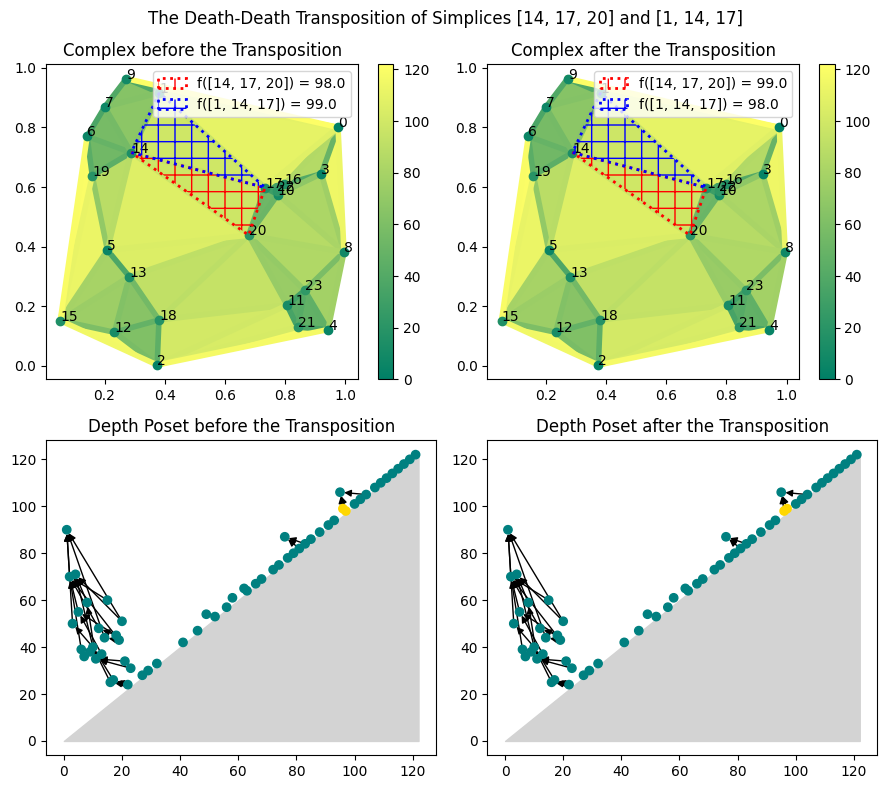

In [12]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, cmap='summer')
plt.tight_layout()

plt.show()

## Classifying the Transpositions

In [13]:
def get_xyab_bb(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-birth case
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_dd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for death-death case
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_bd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-death case
    if transposition['type'] != 'birth-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b
    
def get_xyab(transposition, dp0: DepthPoset):
    # 
    try:
        if transposition['type'] == 'birth-birth':
            return get_xyab_bb(transposition, dp0)
        if transposition['type'] == 'death-death':
            return get_xyab_dd(transposition, dp0)
        if transposition['type'] == 'birth-death':
            return get_xyab_bd(transposition, dp0)
    except UnboundLocalError:
        return None

In [14]:
df_transpositions['xyab'] = [get_xyab(transposition, dp0) for i, transposition in df_transpositions.iterrows()]

assert df_transpositions['xyab'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (90, 10)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(1, 90, 2, 70)"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(2, 70, 3, 50)"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(3, 50, 4, 71)"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(4, 71, 5, 55)"


In [15]:
def get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition):
    # 
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        

In [16]:
(df_transpositions['bd-pairs'], 
 df_transpositions['relations'], 
 df_transpositions['classifying matrix']) = zip(*[get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition) for i, transposition in df_transpositions.iterrows()])


assert df_transpositions['relations'].isna().sum() == 1
assert df_transpositions['classifying matrix'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (90, 13)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab,bd-pairs,relations,classifying matrix
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None,None,None,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(1, 90, 2, 70)","[(121, 122), (119, 120), (117, 118), (115, 116...","[(105, 106), (98, 106), (84, 87), (82, 87), (3...","((1, 0), (1, 1))"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(2, 70, 3, 50)","[(121, 122), (119, 120), (117, 118), (115, 116...","[(105, 106), (98, 106), (84, 87), (82, 87), (3...","((0, 1), (1, 0))"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(3, 50, 4, 71)","[(121, 122), (119, 120), (117, 118), (115, 116...","[(105, 106), (98, 106), (84, 87), (82, 87), (3...","((1, 1), (0, 1))"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(4, 71, 5, 55)","[(121, 122), (119, 120), (117, 118), (115, 116...","[(105, 106), (98, 106), (84, 87), (82, 87), (3...","((0, 1), (1, 0))"


In [17]:
def get_switch_type(stree0, dp0, transposition):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

In [18]:
df_transpositions['switch'] = df_transpositions.apply(lambda row: get_switch_type(stree0, dp0, row), axis=1)

df_transpositions['switch'].value_counts()

switch
no switch          79
switch forward      8
switch backward     3
Name: count, dtype: int64

In [19]:
expected_classifying_matrices = {
    'birth-birth': [((1, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((0, 1), 
                     (1, 1)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)),
                    None, 
                   ], 
    'death-death': [((0, 1), 
                     (1, 1)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((1, 1), 
                     (1, 0)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)), 
                   ],
    'birth-death': [((0, 1, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 1, 0, 0), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 0, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 0)), 
                   ]
}

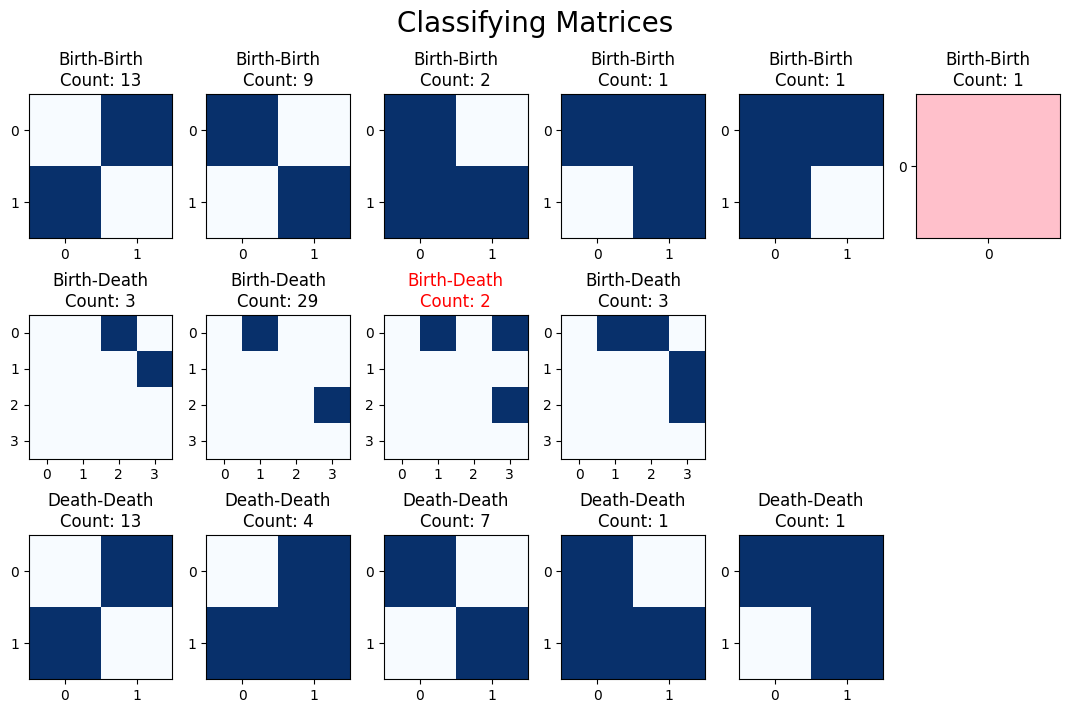

In [20]:
situations = df_transpositions[['type', 'classifying matrix', 'xyab']].fillna('None').rename(columns={'xyab': 'count'})
situations = situations.groupby(['type', 'classifying matrix'], as_index=False).count().replace('None', None)

situations['expected'] = situations.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)


n = situations['type'].value_counts().max()
m = len(pd.unique(situations['type']))
fig, axs = plt.subplots(m, n, figsize=(1.8*n, 2.4*m))
fig.suptitle('Classifying Matrices', fontsize=20)

cmap = plt.get_cmap('Blues')
cmap.set_bad(color='pink')

for j, situation_type in enumerate(pd.unique(situations['type'])):
    these_situations = situations[situations['type'] == situation_type].reset_index(drop=True)
    for i, situation in these_situations.iterrows():
        matrix = these_situations.loc[i, 'classifying matrix']
        if matrix is None:
            matrix = np.nan*np.ones([1, 1])
        matrix = np.array(matrix)
        axs[j, i].set_title(f'{situation_type.replace('b', 'B').replace('d', 'D')}\nCount: {situation['count']}', 
                            color='black' if situation['expected'] else 'red')
        axs[j, i].imshow(matrix, cmap=cmap, vmin=0, vmax=1, origin='upper')
        axs[j, i].set_xticks(np.arange(matrix.shape[1]))
        axs[j, i].set_yticks(np.arange(matrix.shape[0]))
    for i in range(len(these_situations), n):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        for spine in axs[j, i].spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()

In [21]:
df_transpositions['expected'] = df_transpositions.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)

print(f"There are {(~df_transpositions['expected']).sum()} unexpected situations.")


There are 2 unexpected situations.


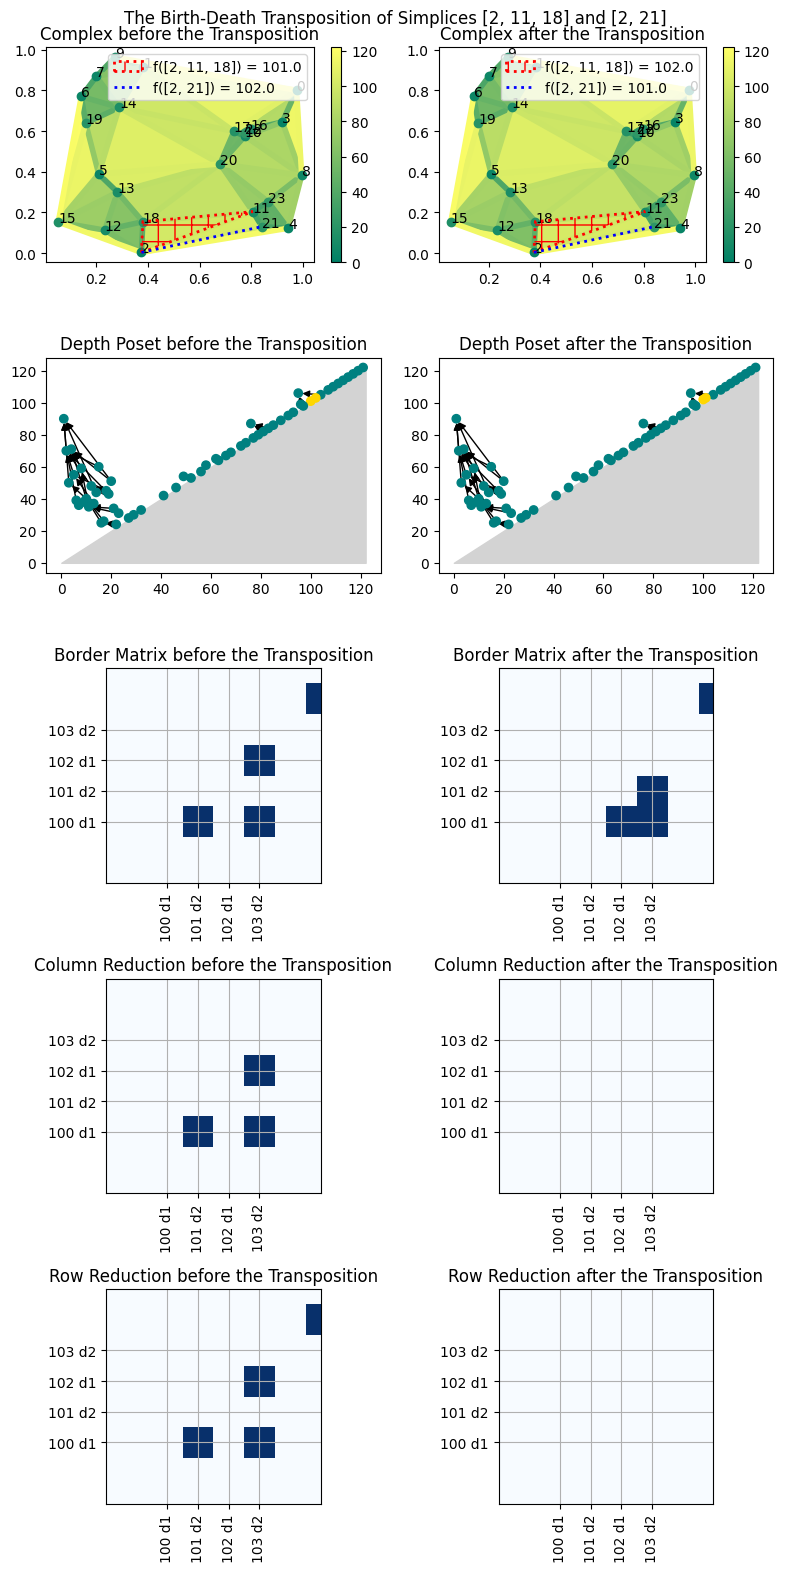

In [22]:
drow_more = True

for i, transposition in df_transpositions[~df_transpositions['expected']].iterrows():
    stree0, stree1 = get_strees(transposition, stree)

    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    fig, axs = plt.subplots(5, 2, figsize=(8, 16))
    fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=fig, axs=axs)

    x, y, a, b = get_xyab(transposition, dp0)
    assert (np.sort([x, y, a, b]) == np.sort(get_xyab(transposition, dp1))).all()
    
    lim_min = np.min([x, y, a, b]) - 2
    lim_max = np.max([x, y, a, b]) + 3
    extents = [(lim_min, lim_min), 
               (lim_min, lim_max), 
               (lim_max, lim_min), 
               (lim_max, lim_max), 
              ]

    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)

    axs[2, 0].set_title('Border Matrix before the Transposition')
    axs[2, 1].set_title('Border Matrix after the Transposition')
    axs[2, 0].imshow(border_matrix0, cmap='Blues', origin='upper')
    axs[2, 1].imshow(border_matrix1, cmap='Blues', origin='upper')
    
    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    alpha0, b00, delta00 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    alpha1, b01, delta01 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)

    axs[3, 0].set_title('Column Reduction before the Transposition')
    axs[3, 1].set_title('Column Reduction after the Transposition')
    axs[3, 0].imshow(delta00, cmap='Blues', origin='upper')
    axs[3, 1].imshow(delta01, cmap='Blues', origin='upper')
    
    omega0, b10, delta10 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
    omega1, b11, delta11 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)

    axs[4, 0].set_title('Row Reduction before the Transposition')
    axs[4, 1].set_title('Row Reduction after the Transposition')
    axs[4, 0].imshow(delta10, cmap='Blues', origin='upper')
    axs[4, 1].imshow(delta11, cmap='Blues', origin='upper')

    ticks = np.sort([x, y, a, b])
    for j2 in [2, 3, 4]:
        axs[j2, 0].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 0].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        axs[j2, 1].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 1].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        for j in range(2):
            axs[j2, j].set_xlim(lim_min, lim_max - 1)
            axs[j2, j].set_ylim(lim_min, lim_max - 1)
            axs[j2, j].grid(True)

    plt.tight_layout()
    plt.savefig(f'pics/unexpected_transposition-{i}.png')

    # Show an example only once
    if drow_more:
        plt.show()
        drow_more = False
    else:
        plt.close()

In [23]:
df_transpositions.groupby(['type', 'switch']).count()

index 0  index 1  value 0  value 1  simplex 0  \
type        switch                                                           
birth-birth no switch             24       24       24       24         24   
            switch backward        2        2        2        2          2   
            switch forward         1        1        1        1          1   
birth-death no switch             34       34       34       34         34   
            switch forward         3        3        3        3          3   
death-death no switch             21       21       21       21         21   
            switch backward        1        1        1        1          1   
            switch forward         4        4        4        4          4   

                             simplex 1  dim 0  dim 1  xyab  bd-pairs  \
type        switch                                                     
birth-birth no switch               24     24     24    23        23   
            switch backward          2      2      2     2         2   
            switch forward           1      1      1     1         1   
birth-death no switch               34     34     34    34        34   
            switch forward           3      3      3     3         3   
death-death no switch               21     21     21    21        21   
            switch backward          1      1      1     1         1   
            switch forward           4      4      4     4         4   

                             relations  classifying matrix  expected  
type        switch                                                    
birth-birth no switch               23                  23        24  
            switch backward          2                   2         2  
            switch forward           1                   1         1  
birth-death no switch               34                  34        34  
            switch forward           3                   3         3  
death-death no switch               21                  21        21  
            switch backward          1                   1         1  
            switch forward           4                   4         4

# Basic Set Difference Measures

In [24]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1
    return len(intersection) / len(union)

# Lemmas and Hypothesises

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
$$


In [25]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-birth') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

'switch backward' will be reformated to 'switch forward'


,forward,backward
index 0,6,6
index 1,7,7
value 0,6.0,6.0
value 1,7.0,7.0
simplex 0,[7],[6]
simplex 1,[6],[7]
dim 0,0,0
dim 1,0,0
type,birth-birth,birth-birth
switch,switch forward,switch backward


Let's denote the sets from Lemma:
1. $\text{Succ}'(a, y)$ - __l31_set0__
2. $\{(x, b)\}$ - __l31_set1__
3. $\text{Succ}'(a, b)$ - __l31_set2__
4. $\{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}$ - __l31_set3__
5. $\text{Succ}'(x, b)$ - __l31_set4__
6. $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$ - __l31_set5__

Now the Lemma 3.1 will be look like
$$
    \textbf{l31\_set0} = \textbf{l31\_set1} \cup \textbf{l31\_set2} \cup \textbf{l31\_set3} 
$$
$$
    \textbf{l31\_set4} = \textbf{l31\_set5}
$$

In [26]:
def l31_set0(stree0, stree1, dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    $
    \text{Succ}'(a, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ay = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sy][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.lower(other, node_ay)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [27]:
l31_set0(stree0, stree1, dp0, dp1, transposition)

[((9,), (1, 9)), ((7,), (6, 7))]

In [28]:
def l31_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(x, b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sx, sb)]

In [29]:
l31_set1(stree0, stree1, dp0, dp1, transposition)

[((7,), (6, 7))]

In [30]:
def l31_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.lower(other, node_ab)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [31]:
l31_set2(stree0, stree1, dp0, dp1, transposition)

[]

In [32]:
def l31_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}'(x, y) | f(t) < f(b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.lower(other, node_xy)
    poset = poset.subposet(node_condition)

    #res = [node.source for node in poset.nodes]
    res = [node.source for node in poset.nodes if node.death_index < b]
    return res 

In [33]:
l31_set3(stree0, stree1, dp0, dp1, transposition)

[]

In [34]:
def jacard_l31a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}'(a, y)$ and $(\{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\})$
    """
    set0 = l31_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = []
    set1 += l31_set1(stree0, stree1, dp0, dp1, transposition)
    set1 += l31_set2(stree0, stree1, dp0, dp1, transposition)
    set1 += l31_set3(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [35]:
jacard_l31a(stree0, stree1, dp0, dp1, transposition)

0.5

In [36]:
set0 = l31_set0(stree0, stree1, dp0, dp1, transposition)
set1 = []
set1 += l31_set1(stree0, stree1, dp0, dp1, transposition)
set1 += l31_set2(stree0, stree1, dp0, dp1, transposition)
set1 += l31_set3(stree0, stree1, dp0, dp1, transposition)

set0 = set(set0)
set1 = set(set1)

In [37]:
set0 - set1

{((9,), (1, 9))}

In [38]:
set1 - set0

set()

In [39]:
def l31_set4(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(x, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xb = [node for node in dp1.nodes if node.source[0] == sx and node.source[1] == sb][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.lower(other, node_xb)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [40]:
l31_set4(stree0, stree1, dp0, dp1, transposition)

[]

In [41]:
def l31_set5(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.lower(other, node_xy)
    poset = poset.subposet(node_condition)

    #res = [node.source for node in poset.nodes]
    res = [node.source for node in poset.nodes if node.death_index > b]
    return res 

In [42]:
l31_set5(stree0, stree1, dp0, dp1, transposition)

[((9,), (1, 9))]

In [43]:
def jacard_l31b(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}'(x, b)$ and $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$
    """
    set0 = l31_set4(stree0, stree1, dp0, dp1, transposition)
    set1 = l31_set5(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [44]:
jacard_l31b(stree0, stree1, dp0, dp1, transposition)

0.0

In [45]:
set0 = set(l31_set4(stree0, stree1, dp0, dp1, transposition))
set1 = set(l31_set5(stree0, stree1, dp0, dp1, transposition))


In [46]:
set0 - set1

set()

In [47]:
set1 - set0

{((9,), (1, 9))}

## Lemma 3.2.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f:X\to R$, $y, b$ are consecutive in the ordering by $f$, and transposition of $y, b$ is a switch. Then
$$
\text{Succ}''(x, b) = \{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}
$$
$$
\text{Succ}''(a, y) = \{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}
$$


In [48]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'death-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(22, 24)]","[(22, 24)]"
classifying matrix,"((0, 1), (1, 1))","((1, 0), (1, 1))"
dim 0,1,1
dim 1,1,1
expected,True,NaN
index 0,24,24
index 1,25,25
relations,"[(22, 10)]","[(22, 16)]"
simplex 0,"[10, 22]","[16, 22]"
simplex 1,"[16, 22]","[10, 22]"


Let's denote these sets:
1. $\text{Succ}''(x, b)$ - __l32_set0__
2. $\{(a, y)\}$ - __l32_set1__
3. $\text{Succ}''(a, b)$ - __l32_set2__
4. $\{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$ - __l32_set3__
5. $\text{Succ}''(a, y)$ - __l32_set4__
6. $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$ - __l32_set5__

Now the Lemma 3.2 will be look like
$$
    \textbf{l32\_set0} = \textbf{l32\_set1} \cup \textbf{l32\_set2} \cup \textbf{l32\_set3} 
$$
$$
    \textbf{l32\_set4} = \textbf{l32\_set5}
$$

In [49]:
def l32_set0(stree0, stree1, dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    $
    \text{Succ}''(x, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xb = [node for node in dp1.nodes if node.source[0] == sx and node.source[1] == sb][0]

    poset = dp1.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.lower(other, node_xb)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [50]:
l32_set0(stree0, stree1, dp0, dp1, transposition)

[]

In [51]:
def l32_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(a, y)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sa, sy)]

In [52]:
l32_set1(stree0, stree1, dp0, dp1, transposition)

[((16,), (10, 22))]

In [53]:
def l32_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.lower(other, node_ab)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [54]:
l32_set2(stree0, stree1, dp0, dp1, transposition)

[]

In [55]:
def l32_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.lower(other, node_xy)
    poset = poset.subposet(node_condition)

    #res = [node.source for node in poset.nodes]
    res = [node.source for node in poset.nodes if a < node.birth_index and node.birth_index < x]
    return res 

In [56]:
l32_set3(stree0, stree1, dp0, dp1, transposition)

[]

In [57]:
def jacard_l32a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}''(x, b)$ and $\{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$
    """
    set0 = l32_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = []
    set1 += l32_set1(stree0, stree1, dp0, dp1, transposition)
    set1 += l32_set2(stree0, stree1, dp0, dp1, transposition)
    set1 += l32_set3(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [58]:
jacard_l32a(stree0, stree1, dp0, dp1, transposition)

0.0

In [59]:
set0 = l32_set0(stree0, stree1, dp0, dp1, transposition)
set1 = []
set1 += l32_set1(stree0, stree1, dp0, dp1, transposition)
set1 += l32_set2(stree0, stree1, dp0, dp1, transposition)
set1 += l32_set3(stree0, stree1, dp0, dp1, transposition)

set0 = set(set0)
set1 = set(set1)

In [60]:
set0 - set1

set()

In [61]:
set1 - set0

{((16,), (10, 22))}

In [62]:
def l32_set4(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ay = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sy][0]

    poset = dp1.get_column_bottom_to_top_reduction()
    node_condition = lambda other: poset.lower(other, node_ay)
    poset = poset.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [63]:
l32_set4(stree0, stree1, dp0, dp1, transposition)

[((22,), (16, 22))]

In [64]:
def l32_set5(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]

    poset = dp0.get_row_left_to_right_reduction()
    node_condition = lambda other: poset.lower(other, node_xy)
    poset = poset.subposet(node_condition)

    #res = [node.source for node in poset.nodes]
    res = [node.source for node in poset.nodes if node.birth_index < a]
    return res 

In [65]:
l32_set5(stree0, stree1, dp0, dp1, transposition)

[]

In [66]:
def jacard_l32b(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}''(a, y)$ and $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$
    """
    set0 = l32_set4(stree0, stree1, dp0, dp1, transposition)
    set1 = l32_set5(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [67]:
jacard_l32b(stree0, stree1, dp0, dp1, transposition)

0.0

In [68]:
set0 = l32_set4(stree0, stree1, dp0, dp1, transposition)
set1 = l32_set5(stree0, stree1, dp0, dp1, transposition)

set0 = set(set0)
set1 = set(set1)

In [69]:
set0 - set1

{((22,), (16, 22))}

In [70]:
set1 - set0

set()

## Lemma 3.3.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f$: $X\to R$, $b, x$ are consecutive in the ordering by $f$, and the transposition of $b, x$ is a switch. Then
$$
\text{Succ}(a, x) = \text{Succ}(a, b)
\;\;\text{and}\;\; 
\text{Succ}(b, y) = \text{Succ}(x, y)
$$


In [71]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(121, 122), (119, 120), (117, 118), (115, 116...","[(121, 122), (119, 120), (117, 118), (115, 116..."
classifying matrix,"((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,...","((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,..."
dim 0,1,1
dim 1,1,1
expected,True,NaN
index 0,90,90
index 1,91,91
relations,"[(105, 106), (98, 106), (22, 10), (16, 10), (1...","[(105, 106), (98, 106), (22, 10), (16, 10), (1..."
simplex 0,"[18, 20]","[13, 20]"
simplex 1,"[13, 20]","[18, 20]"


Let's again rename the sets:
1. $\text{Succ}(a, x)$ - __l33_set0__ 
1. $\text{Succ}(a, b)$ - __l33_set1__ 
1. $\text{Succ}(b, y)$ - __l33_set2__ 
1. $\text{Succ}(x, y)$ - __l33_set3__ 

In [72]:
def l33_set0(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, x)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ax = [node for node in dp1.nodes if node.source[0] == sa and node.source[1] == sx][0]
    
    node_condition = lambda other: dp1.lower(other, node_ax)
    poset = dp1.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [73]:
l33_set0(stree0, stree1, dp0, dp1, transposition)

[((22,), (10, 22)),
 ((20,), (10, 20)),
 ((19,), (6, 19)),
 ((18,), (2, 18)),
 ((17,), (17, 22)),
 ((16,), (16, 22)),
 ((15,), (12, 15)),
 ((14,), (14, 19)),
 ((13,), (5, 13)),
 ((12,), (12, 18)),
 ((10,), (3, 16)),
 ((9,), (1, 9)),
 ((7,), (6, 7)),
 ((6,), (7, 9)),
 ((5,), (13, 18)),
 ((3,), (0, 3)),
 ((2,), (5, 19))]

In [74]:
def l33_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_ab = [node for node in dp0.nodes if node.source[0] == sa and node.source[1] == sb][0]
    
    node_condition = lambda other: dp0.lower(other, node_ab)
    poset = dp0.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [75]:
l33_set1(stree0, stree1, dp0, dp1, transposition)

[((22,), (10, 22)),
 ((20,), (10, 20)),
 ((19,), (6, 19)),
 ((18,), (2, 18)),
 ((17,), (17, 22)),
 ((16,), (16, 22)),
 ((15,), (12, 15)),
 ((14,), (14, 19)),
 ((13,), (5, 13)),
 ((12,), (12, 18)),
 ((10,), (3, 16)),
 ((9,), (1, 9)),
 ((7,), (6, 7)),
 ((6,), (7, 9)),
 ((5,), (13, 18)),
 ((3,), (0, 3)),
 ((2,), (5, 19))]

In [76]:
def jacard_l33a(stree0, stree1, dp0, dp1, transposition):
    """
    Jacard Index of $\text{Succ}(a, x)$ and $\text{Succ}(a, b)$
    """
    set0 = l33_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = l33_set1(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [77]:
jacard_l33a(stree0, stree1, dp0, dp1, transposition)

1.0

In [78]:
set0 = set(l33_set0(stree0, stree1, dp0, dp1, transposition))
set1 = set(l33_set1(stree0, stree1, dp0, dp1, transposition))

len(set0 - set1), len(set1 - set0), 

(0, 0)

In [79]:
def l33_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(b, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_by = [node for node in dp1.nodes if node.source[0] == sb and node.source[1] == sy][0]
    
    node_condition = lambda other: dp1.lower(other, node_by)
    poset = dp1.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [80]:
def l33_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(x, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    node_xy = [node for node in dp0.nodes if node.source[0] == sx and node.source[1] == sy][0]
    
    node_condition = lambda other: dp0.lower(other, node_xy)
    poset = dp0.subposet(node_condition)

    return [node.source for node in poset.nodes]

In [81]:
def jacard_l33b(stree0, stree1, dp0, dp1, transposition):
    """
    Jacard Index of $\text{Succ}(b, y)$ and $\text{Succ}(x, y)$
    """
    set0 = l33_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = l33_set1(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [82]:
jacard_l33b(stree0, stree1, dp0, dp1, transposition)

1.0

In [83]:
set0 = set(l33_set2(stree0, stree1, dp0, dp1, transposition))
set1 = set(l33_set3(stree0, stree1, dp0, dp1, transposition))

len(set0 - set1), len(set1 - set0), 

(0, 0)

## General Scores

In [84]:
def jacard_nodes_filtration(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of node sets from 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    set0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    set1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(set0, set1)

In [85]:
def jacard_nodes_simplex(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of nodes from 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    set0 = [node.source for node in dp0.nodes]
    set1 = [node.source for node in dp1.nodes]
    return jacard_index(set0, set1)

In [86]:
def jacard_edges_filtration(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g0.edges]
    set1 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

In [87]:
def jacard_edges_simplex(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [(n0.source, n1.source) for n0, n1 in g0.edges]
    set1 = [(n0.source, n1.source) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

## Hypothesis 1: 
Suppose $a$ and $b$ are 2-simplices consecutive in the ordering by $f$. And there is another Morse function $f^*$: 
$$
f^*(s) = 
\begin{cases}
f(s), \; \text{if} \; s\ne a, b \\
f(b), \; \text{if} \; s = a \\
f(a), \; \text{if} \; s = b
\end{cases}
$$
Let's denote $DP_{f}$ the transitive reduction of the Depth Poset defined by the filtration $f$. And let's deonote $DP_{f}(s)$ the set of nodes in $DP_f(s)$ which are pairs containing cell $s$ and the set of edges with these nodes.

__Hypothesis:__ if the cell $s$ has no faces and cofaces with $a$ and $b$, then $DP_f(s) = DP_{f^*}(s)$.

In [88]:
def unique(input_list):
    """
    Returns the list of unique elements in input_list
    """
    seen = set()
    result = []
    
    for elem in input_list:
        if isinstance(elem, np.ndarray):
            # Convert np.array to a tuple for hashable representation
            identifier = (np.ndarray, elem.shape, tuple(elem.ravel()))
        else:
            # Use the element directly for hashable types
            identifier = elem
        
        # Check for uniqueness
        if identifier not in seen:
            seen.add(identifier)
            result.append(elem)
    
    return result

In [89]:
def is_face_coface_pair(face, coface):
    """
    Returns True if the given pair of simolices are face and coface to each other
    """
    if len(face) + 1 != len(coface):
        return False
    return tuple(np.sort(face)) == tuple(np.sort(np.intersect1d(face, coface)))

In [90]:
def get_faces(simplices, coface):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(simplex, coface):
            res.append(simplex)
    return res

In [91]:
def get_cofaces(simplices, face):
    """
    """
    res = []
    for simplex in simplices:
        if is_face_coface_pair(face, simplex):
            res.append(simplex)
    return res

In [92]:
def get_cofaces_of_faces(simplices, simplex):
    """
    """
    res = []
    for face in get_faces(simplices, simplex):
        res += list(get_cofaces(simplices, face))
    return unique(res)

In [93]:
def get_faces_of_cofaces(simplices, simplex):
    """
    """
    res = []
    for coface in get_cofaces(simplices, simplex):
        res += list(get_faces(simplices, coface))
    return unique(res)

In [94]:
def exclude_transposition_from_nodes(nodes, s0, s1, simplices=None):
    """
    Returns the list of nodes, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = unique([node.source[0] for node in nodes] + [node.source[1] for node in nodes])
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: node.source[0] not in simplices_to_exclude and node.source[1] not in simplices_to_exclude
    
    return [node for node in nodes if node_condition(node)]

In [95]:
def exclude_transposition_from_edges(edges, s0, s1, simplices=None):
    """
    Returns the list of edges, filtered, that node simplices are not transposition neighbours.
    Two simplices are neighbours, if they have one face or coface.
    """
    if simplices is None:
        simplices = []
        for edge in edges:
            simplices += [node.source[0] for node in edge] + [node.source[1] for node in edge]
        simplices = unique(simplices)
    
    simplices_to_exclude = unique(get_cofaces_of_faces(simplices, s0) + \
                                  get_cofaces_of_faces(simplices, s1) + \
                                  get_faces_of_cofaces(simplices, s0) + \
                                  get_faces_of_cofaces(simplices, s1) )
    node_condition = lambda node: node.source[0] not in simplices_to_exclude and node.source[1] not in simplices_to_exclude
    edge_condition = lambda edge: node_condition(edge[0]) and node_condition(edge[1])
    
    return [edge for edge in edges if edge_condition(edge)]

In [96]:
def jacard_nodes_excluding_neighbours(dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    The Jacard index of subsets of nodes $(s, t)$ from 2 depth posets, s.t. 
    $s, t \notin \nabla\partial\sigma_0 \cup \partial\nabla\sigma_0 \cup \nabla\partial\sigma_1 \cup \partial\nabla\sigma_1$,
    where $\sigma_0$ and $\sigma_1$ are transposing simplices.
    """
    s0, s1 = transposition[['simplex 0', 'simplex 1']]

    set0 = exclude_transposition_from_nodes(dp0.nodes, s0, s1)
    set1 = exclude_transposition_from_nodes(dp1.nodes, s0, s1)

    return jacard_index(set0, set1)

In [97]:
jacard_nodes_excluding_neighbours(dp0, dp1, transposition)

1.0

In [98]:
def jacard_edges_excluding_neighbours(dp0: DepthPoset, dp1: DepthPoset, transposition):
    r"""
    The Jacard index of subsets of edges $((s_0, t_0), (s_1, t_1))$ from 2 depth posets, s.t. 
    $s_0, t_0, s_1, t_1 \notin \nabla\partial\sigma_0 \cup \partial\nabla\sigma_0 \cup \nabla\partial\sigma_1 \cup \partial\nabla\sigma_1$,
    where $\sigma_0$ and $\sigma_1$ are transposing simplices.
    """
    s0, s1 = transposition[['simplex 0', 'simplex 1']]

    
    set0 = exclude_transposition_from_edges(dp0.get_transitive_reduction().edges, s0, s1)
    set1 = exclude_transposition_from_edges(dp1.get_transitive_reduction().edges, s0, s1)

    return jacard_index(set0, set1)

In [99]:
jacard_edges_excluding_neighbours(dp0, dp1, transposition)

1.0

# Scores

In [100]:
problems_scores = {'General': [jacard_nodes_filtration, 
                               jacard_nodes_simplex, 
                               jacard_edges_filtration, 
                               jacard_edges_simplex, 
                              ], 
                   'Lemma 3.1': [jacard_l31a, jacard_l31b], 
                   'Lemma 3.2': [jacard_l32a, jacard_l32b], 
                   'Lemma 3.3': [jacard_l33a, jacard_l33b], 
                   'Hypothesis': [jacard_nodes_excluding_neighbours, 
                                  jacard_edges_excluding_neighbours], 
                  }

scores = unique(np.concatenate(list(problems_scores.values())))
scores

[<function __main__.jacard_nodes_filtration(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_nodes_simplex(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_edges_filtration(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_edges_simplex(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset)>,
 <function __main__.jacard_l31a(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l31b(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l32a(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l32b(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l33a(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_l33b(stree0, stree1, dp0, dp1, transposition)>,
 <function __main__.jacard_nodes_excluding_neighbours(dp0: src.depth.DepthPoset, dp1: src.depth.DepthPoset, transposition)>,
 <function __main__.jacard_edge

In [101]:
results = []

for i, transposition in tqdm(df_transpositions.iterrows(), total=len(df_transpositions)):
    # 
    stree0, stree1 = get_strees(transposition, stree)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    results_i = {}
    for score in scores:
        param_names = inspect.signature(score).parameters.keys()
        args = {name: value for name, value in locals().items() if name in param_names}
        try:
            value = score(**args)
        except Exception as err:
            value = None
        results_i.update({score.__name__: value})
    results.append(results_i)

results = pd.DataFrame(results)

df_transpositions = df_transpositions[np.setdiff1d(df_transpositions.columns, results.columns)]
df_transpositions = df_transpositions.join(results)

interesting_cols = np.concatenate([['value 0', 'value 1', 'simplex 0', 'simplex 1'], 
                                   ['type', 'switch'], 
                                   [score.__name__ for score in scores]])

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions[interesting_cols].head()

100%|███████████████████████████████████████████| 90/90 [00:11<00:00,  8.09it/s]

df_transpositions.shape = (90, 27)


,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nodes_excluding_neighbours,jacard_edges_excluding_neighbours
0,0.0,1.0,[0],[1],birth-birth,no switch,1.000000,0.967742,0.906250,0.794118,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,1.0,2.0,[1],[2],birth-birth,switch backward,1.000000,0.936508,0.794118,0.564103,0.2,0.0,0.0,0.0,NaN,NaN,1.0,1.0
2,2.0,3.0,[2],[3],birth-birth,no switch,0.936508,1.000000,0.589744,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,3.0,4.0,[3],[4],birth-birth,no switch,0.936508,1.000000,0.722222,0.937500,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,4.0,5.0,[4],[5],birth-birth,no switch,0.936508,1.000000,0.675676,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [102]:
df_transpositions[df_transpositions['switch'] != 'no switch'][interesting_cols]

,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nodes_excluding_neighbours,jacard_edges_excluding_neighbours
1,1.0,2.0,[1],[2],birth-birth,switch backward,1.0,0.936508,0.794118,0.564103,0.200000,0.0,0.0,0.0,NaN,NaN,1.0,1.0
6,6.0,7.0,[6],[7],birth-birth,switch backward,1.0,0.936508,1.000000,0.823529,0.000000,0.0,0.0,0.0,NaN,NaN,1.0,1.0
24,24.0,25.0,"[10, 22]","[16, 22]",death-death,switch forward,1.0,0.936508,1.000000,0.823529,0.500000,1.0,0.0,0.0,NaN,NaN,1.0,1.0
31,34.0,35.0,"[11, 21]","[4, 21]",death-death,switch backward,1.0,0.936508,1.000000,0.823529,0.500000,1.0,0.0,0.0,NaN,NaN,1.0,1.0
35,38.0,39.0,"[1, 9]","[7, 9]",death-death,switch forward,1.0,0.936508,1.000000,0.823529,0.666667,1.0,0.0,0.0,NaN,NaN,1.0,1.0
39,43.0,44.0,"[6, 19]","[14, 19]",death-death,switch forward,1.0,0.936508,0.906250,0.848485,0.500000,1.0,0.0,0.0,NaN,NaN,1.0,1.0
46,51.0,52.0,"[10, 20]","[17, 20]",birth-death,switch forward,1.0,0.936508,1.000000,0.878788,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
61,71.0,72.0,"[20, 23]","[11, 20]",birth-death,switch forward,1.0,0.936508,1.000000,0.823529,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
72,90.0,91.0,"[18, 20]","[13, 20]",birth-death,switch forward,1.0,0.936508,1.000000,0.771429,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0
75,95.0,96.0,"[14, 17]","[1, 17]",birth-birth,switch forward,1.0,0.936508,0.937500,0.823529,0.333333,0.0,0.0,0.0,NaN,NaN,1.0,1.0


## Raporting

In [103]:
def row_is_switch_bb(row):
    # 
    return row['type'] == 'birth-birth' and row['switch'] == 'switch forward'

def row_is_switch_bd(row):
    # 
    return row['type'] == 'birth-death' and row['switch'] == 'switch forward'

def row_is_switch_dd(row):
    # 
    return row['type'] == 'death-death' and row['switch'] == 'switch forward'

def row_is_any(row):
    # 
    return True


score_condition_expectation = {}

for score in problems_scores['Lemma 3.1']:
    score_condition_expectation.update({score.__name__: {row_is_switch_bb: 1}})
for score in problems_scores['Lemma 3.2']:
    score_condition_expectation.update({score.__name__: {row_is_switch_dd: 1}})
for score in problems_scores['Lemma 3.3']:
    score_condition_expectation.update({score.__name__: {row_is_switch_bd: 1}})
for score in problems_scores['Hypothesis']:
    score_condition_expectation.update({score.__name__: {row_is_any: 1}})

score_condition_expectation = pd.DataFrame(score_condition_expectation)
score_condition_expectation

,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b,jacard_nodes_excluding_neighbours,jacard_edges_excluding_neighbours
<function row_is_switch_bb at 0x78f8f1be87c0>,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
<function row_is_switch_dd at 0x78f8f1be8040>,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
<function row_is_switch_bd at 0x78f8f1bebba0>,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
<function row_is_any at 0x78f8f1bea160>,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [104]:
problems_scores_with_expectation = {}
problems_unexpected_cases = {}

for problem in problems_scores.keys():
    scores_with_expectation =  np.intersect1d(score_condition_expectation.columns, [score.__name__ for score in problems_scores[problem]])
    problems_scores_with_expectation.update({problem: list(scores_with_expectation)})

    unexpected_cases = df_transpositions.apply(lambda row: False, axis=1)
    for score in scores_with_expectation:
        for condition in score_condition_expectation[score_condition_expectation[score].notna()].index:
            expected_value = score_condition_expectation.loc[[condition], score].values[0]
            unexpected_cases = unexpected_cases | (df_transpositions.apply(condition, axis=1) & (df_transpositions[score] != expected_value))
    problems_unexpected_cases.update({problem: df_transpositions[unexpected_cases].index})


In [124]:
unexpected_indices_drown = np.unique(np.concatenate(list(problems_unexpected_cases.values())))
unexpected_indices_drown = np.random.choice(unexpected_indices_drown, min(len(unexpected_indices_drown), 6), replace=False)
unexpected_indices_drown = np.sort(unexpected_indices_drown)
unexpected_indices_drown

# 1. отрисовать транспозиции по выбранным индексам
# 2. добавить референсы к отрисованным индексам в таблицы df_unexpected_cases
# 3. Вставить изображения в строку s_unexpected_cases

array([24, 35, 39, 75, 81])

In [110]:
s_unexpected_cases = ''

for problem in np.setdiff1d(list(problems_scores.keys()), ['General']):
    df_unexpected_cases = df_transpositions.loc[problems_unexpected_cases[problem], 
                                                np.concatenate([['index 0', 'index 1', 
                                                                 'simplex 0', 'simplex 1', 
                                                                 'type', 'switch'], problems_scores_with_expectation[problem]])]
    
    df_unexpected_cases_latex = df_unexpected_cases.to_latex(index=False, float_format="{:.2f}".format)
    df_unexpected_cases_latex = f'\\begin{{center}}\n{df_unexpected_cases_latex}\\end{{center}}' 
    df_unexpected_cases_latex = f': \n{df_unexpected_cases_latex}.' if len(df_unexpected_cases) else '. '
    
    s_unexpected_cases += f"""
    \\par The {problem} problem can be measured by {len(problems_scores_with_expectation[problem])} scores with expected 
    values{': ' + ', '.join(problems_scores_with_expectation[problem]) if len(problems_scores_with_expectation[problem]) else '' }.
    There are {len(df_unexpected_cases)} cases, which does not require the expectations{df_unexpected_cases_latex}
    """

print(s_unexpected_cases)


    \par The Hypothesis problem can be measured by 2 scores with expected 
    values: jacard_edges_excluding_neighbours, jacard_nodes_excluding_neighbours.
    There are 0 cases, which does not require the expectations. 
    
    \par The Lemma 3.1 problem can be measured by 2 scores with expected 
    values: jacard_l31a, jacard_l31b.
    There are 1 cases, which does not require the expectations: 
\begin{center}
\begin{tabular}{rrllllrr}
\toprule
index 0 & index 1 & simplex 0 & simplex 1 & type & switch & jacard_l31a & jacard_l31b \\
\midrule
95 & 96 & [14, 17] & [1, 17] & birth-birth & switch forward & 0.33 & 0.00 \\
\bottomrule
\end{tabular}
\end{center}.
    
    \par The Lemma 3.2 problem can be measured by 2 scores with expected 
    values: jacard_l32a, jacard_l32b.
    There are 4 cases, which does not require the expectations: 
\begin{center}
\begin{tabular}{rrllllrr}
\toprule
index 0 & index 1 & simplex 0 & simplex 1 & type & switch & jacard_l32a & jacard_l32b \\
\midrule
